# Penalised Unexplainability Network for Payments Per Claim Incurred

This notebook is intended to introduce the Penalised Unexplainability Network for Payments Per Claim Incurred model, a granular model for risk pricing and loss reserving, which separates out the "unexplainable" component of the residual network and assigns a separate penalty factor to it.

This model is intended to be useful where:

* Risk pricing where IBNR may vary with risk details, or
* Loss reserving where a mix shift has changed the portfolio significantly,
* and there is a reasonable sample size for a granular model to operate.

Firstly some imports:

In [1]:
import pandas as pd
import numpy as np
import punppci as pn
from punppci.example import fetch_example_data

In this example we will use a "claims" dataset which is based on airline delays. That has 12 columns of claim counts and paids.

In [2]:
prefix = "example"
num_cols = 12

df = fetch_example_data() # Get example data frame

We will convert the DataFrame into a pn.InsuranceDataset which enables convenience functions, but is not a strict requirement as models have a scikit-learn API. Setting as_at_date will mask the data at a certain date. All the claims past that date will get set to NaNs.

In [3]:
# Make Dataset
ds = pn.InsuranceDataset(
    features=df[["carrier", "flight", "departing", "destination", "distance"]],
    origin=df.origin_date,
    claim_count=df[["claim_count_{}".format(x) for x in range(0, num_cols)]],
    claim_paid=df[["claim_paid_{}".format(x) for x in range(0, num_cols)]],
    as_at_date=df.origin_date.agg("max")
)

In [4]:
df.origin_date.agg("max")

Timestamp('2014-01-31 00:00:00')

Convenience functions include plotting the triangle as a Seaborn heatmap:

(<Figure size 864x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2f112c18>)

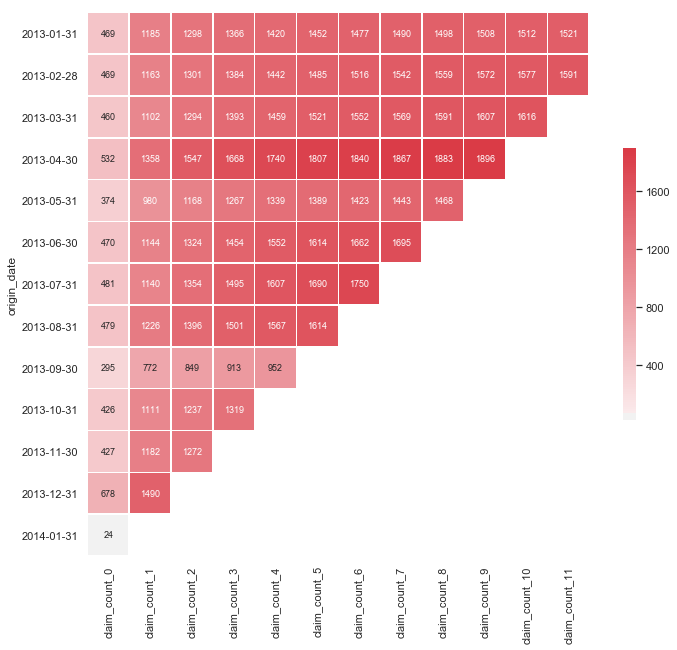

In [5]:
# Cumulative Count Triangle and Heat Map
ds.plot_triangle_claim_count()

(<Figure size 864x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2f0eb160>)

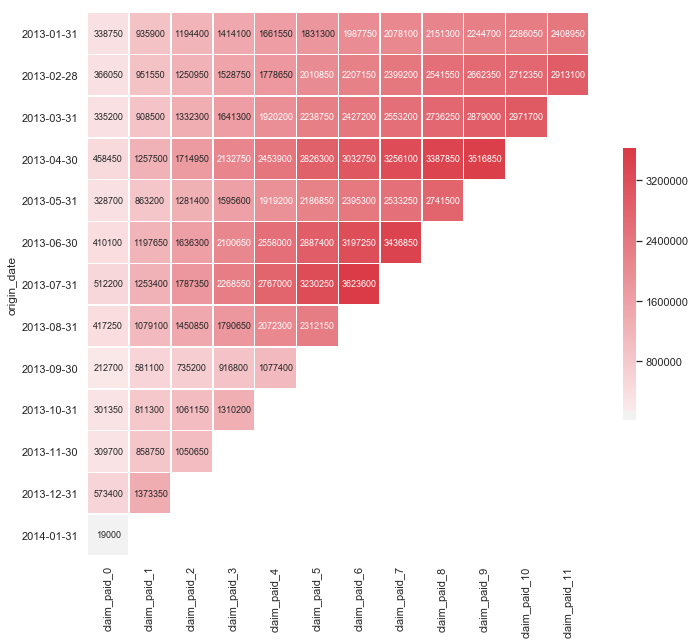

In [6]:
# Cumulative paid triangle and heatmap
ds.plot_triangle_claim_paid()

With this the bottom half of the triangle can be predicted using the traditional PPCI method:

In [7]:
len(ds.claim_paid.columns)

12

(<Figure size 864x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2f0eb668>)

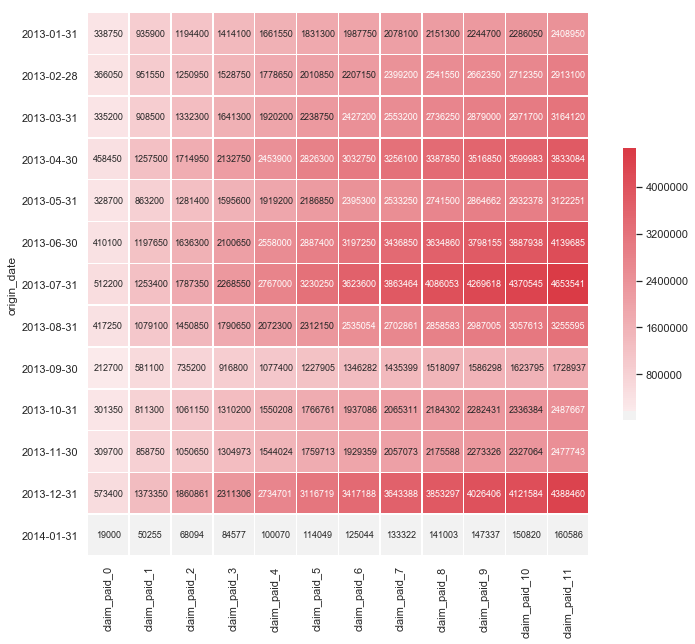

In [8]:
# Standard Chain Ladder Projection
paidcl = pn.ChainLadderRegressor("claim_paid")
paidcl.fit(ds.X(paidcl), ds.y(paidcl))
ds.plot_triangle_claim_paid(paidcl)

(<Figure size 864x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2f097ac8>)

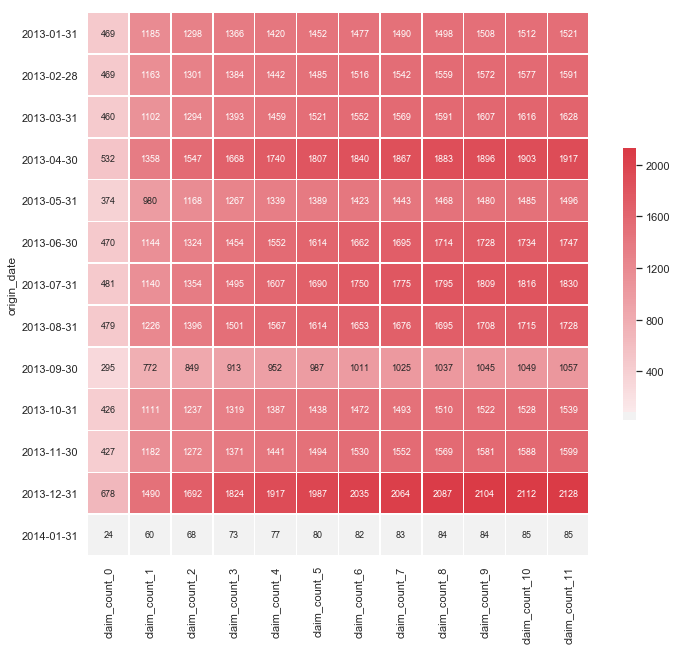

In [9]:
# Standard Chain Ladder Projection
countcl = pn.ChainLadderRegressor("claim_count")
countcl.fit(ds.X(countcl), ds.y(countcl))
ds.plot_triangle_claim_count(countcl)

(<Figure size 864x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2f066978>)

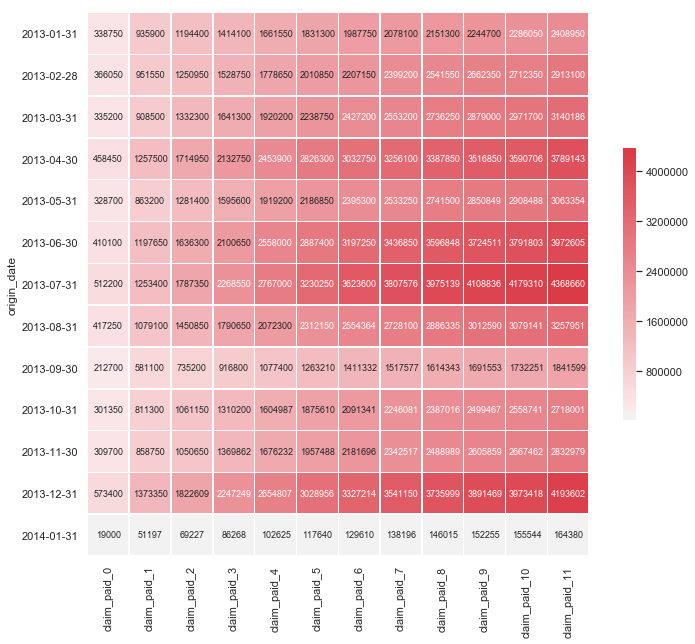

In [10]:
# Standard PPCI Projection
ppci = pn.PPCIRegressor()
ppci.fit(ds.X(ppci), ds.y(ppci))
ds.plot_triangle_claim_paid(ppci)

However the primary goal of the package is to predict claims using the PUNPPCI model. 

We can create an Estimator based on a Dataset as follows - this will take on the list of predictors and the categories:

In [11]:
# Model - Make, Fit and Predict
model = pn.PUNPPCIClaimRegressor()

Auto detect categorical dimensions to be: [(1, 15), (2, 2), (3, 101)]
Setting maximum learn rate to 0.1.
Setting epochs for training model to 14
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    86712.7158    93588.0859  1.9589
      2    85360.7607    93028.3398  1.9362
      3    85351.1787    93080.1875  1.8769
      4    85187.0137    93021.3281  2.1885
      5    84966.5039    92830.3281  1.8811
      6    84976.4609    92837.3164  1.9807
      7    84933.3574    92820.1016  2.2075
      8    84837.9824    92819.5664  1.8458
      9    84825.3818    92691.1016  2.3191
     10    84930.4180    92809.7969  2.4207
     11    84864.4570    92867.8594  1.9958
     12    84848.5303    92780.0508  2.0552
     13    84854.7441    92733.1406  1.9421
     14    84950.0645    93242.6914  2.0739


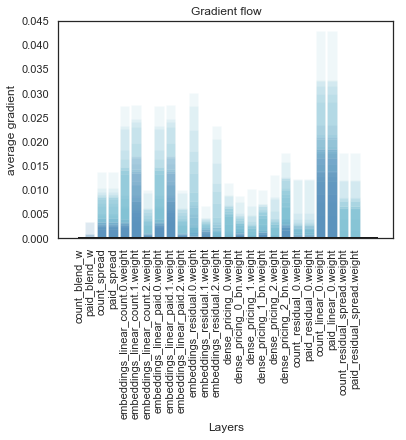

In [12]:
# Fit with optional exposure weights
model.fit(ds.X(model), ds.y(model), w=ds.w(model))

The model can be used to project the bottom half of the triangle:

(<Figure size 864x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2f01d5f8>)

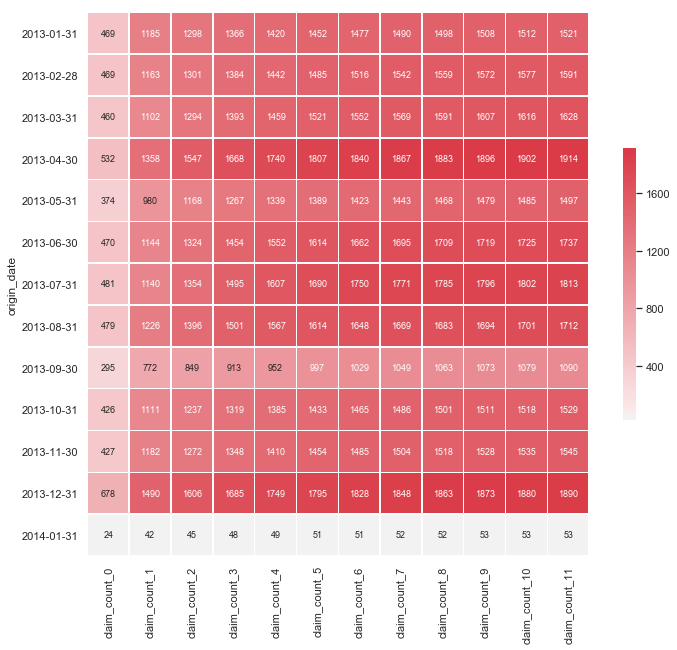

In [13]:
ds.plot_triangle_claim_count(model)

(<Figure size 864x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2efe4208>)

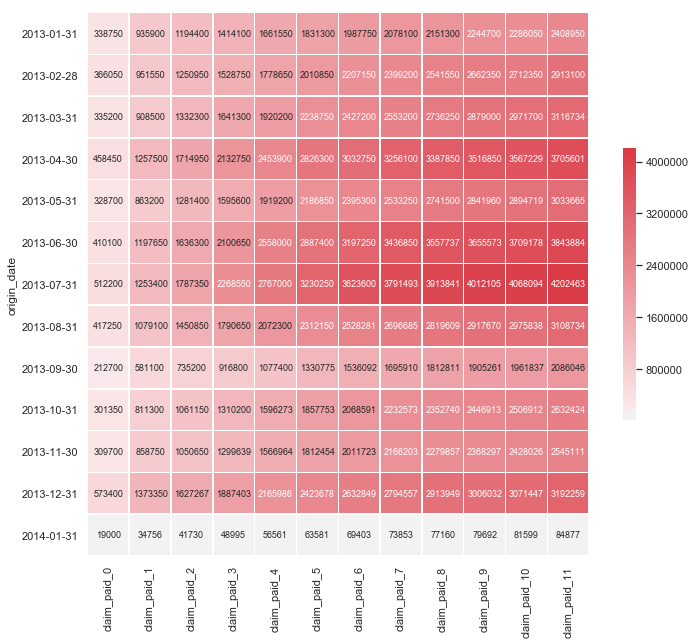

In [14]:
ds.plot_triangle_claim_paid(model)

The weights within the final model of linear vs residual neural network components can be displayed as follows:

In [15]:
model.get_weights()

{'count_blend_w': Parameter containing:
 tensor([-0.0781], requires_grad=True), 'paid_blend_w': Parameter containing:
 tensor([-1.4060], requires_grad=True), 'count_spread': Parameter containing:
 tensor([-2.1277, -1.7465, -3.2956, -3.7154, -4.0149, -4.2831, -4.6392, -5.1031,
         -5.3743, -5.7085, -6.5645, -5.8555], requires_grad=True), 'paid_spread': Parameter containing:
 tensor([6.7744, 6.8559, 7.7338, 8.1173, 8.4512, 8.6168, 8.8176, 9.0070, 9.1047,
         9.1666, 9.1466, 9.4822], requires_grad=True), 'embeddings_linear_count.0.weight': Parameter containing:
 tensor([[ 0.0713],
         [-0.1185],
         [-0.1707],
         [ 0.1329],
         [-0.1581],
         [ 0.3048],
         [ 0.0572],
         [-0.0926],
         [-0.1012],
         [ 0.0238],
         [-0.0030],
         [-0.2255],
         [-0.1347],
         [-0.1611],
         [ 0.1168],
         [ 0.2430]], requires_grad=True), 'embeddings_linear_count.1.weight': Parameter containing:
 tensor([[-0.0995],
     

The model is a standard scikit-learn estimator, so predictions can be generated in the usual way:

For both models, it is possible to just predict frequency and size.

In [20]:
# Predict frequency
model.predict(ds.X(model), response_variable="frequency").head(5)

0    0.367416
1    0.367278
2    0.224480
3    0.342108
4    0.238327
dtype: float32

In [21]:
# Predict size
model.predict(ds.X(model), response_variable="size").head(5)

0    1579.141113
1    1707.863403
2    1078.042358
3    1512.157104
4    1187.489746
dtype: float32

Partial dependence plots are included with the package using PDPBox:

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a3009cba8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a30096908>})

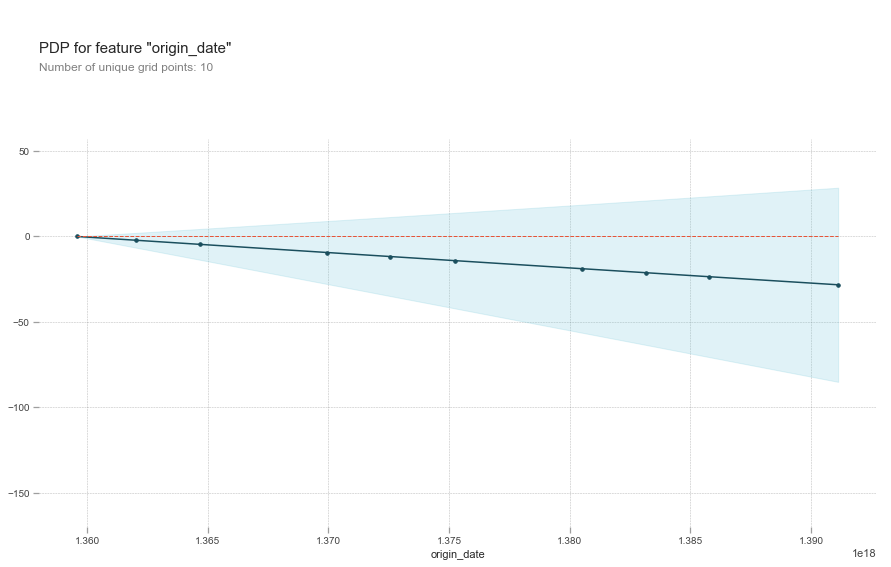

In [19]:
# Partial Dependence - Frequency
model.plot_pdp_frequency(ds, 'origin_date')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2efefe10>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2efd9978>})

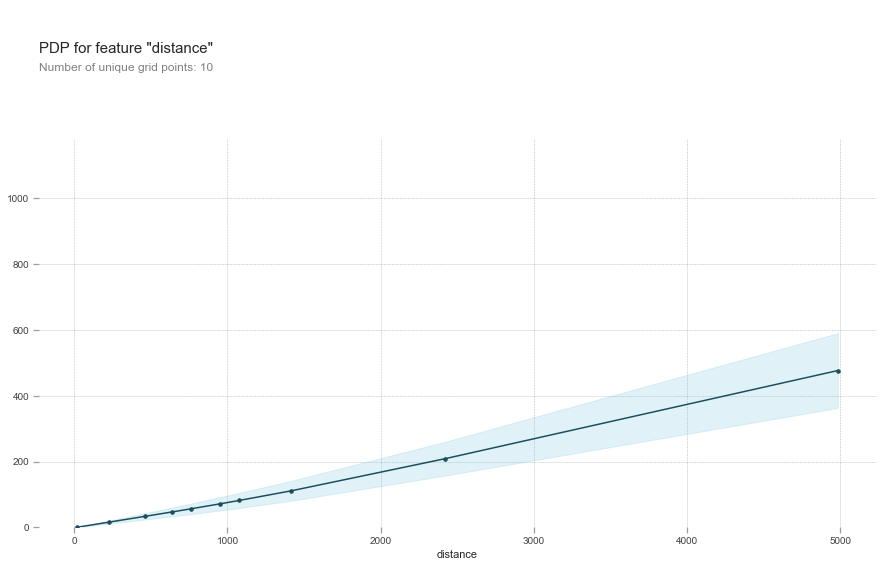

In [22]:
# Partial Dependence - Size
model.plot_pdp_size(ds, 'distance')

The network graph can also be displayed, but a smaller scale may be needed to fit on screen.

In [20]:
from IPython.display import HTML
# Smaller graph so it can fit on screen
style = "<style>svg{width:50% !important;height:50% !important;}</style>"
HTML(style)

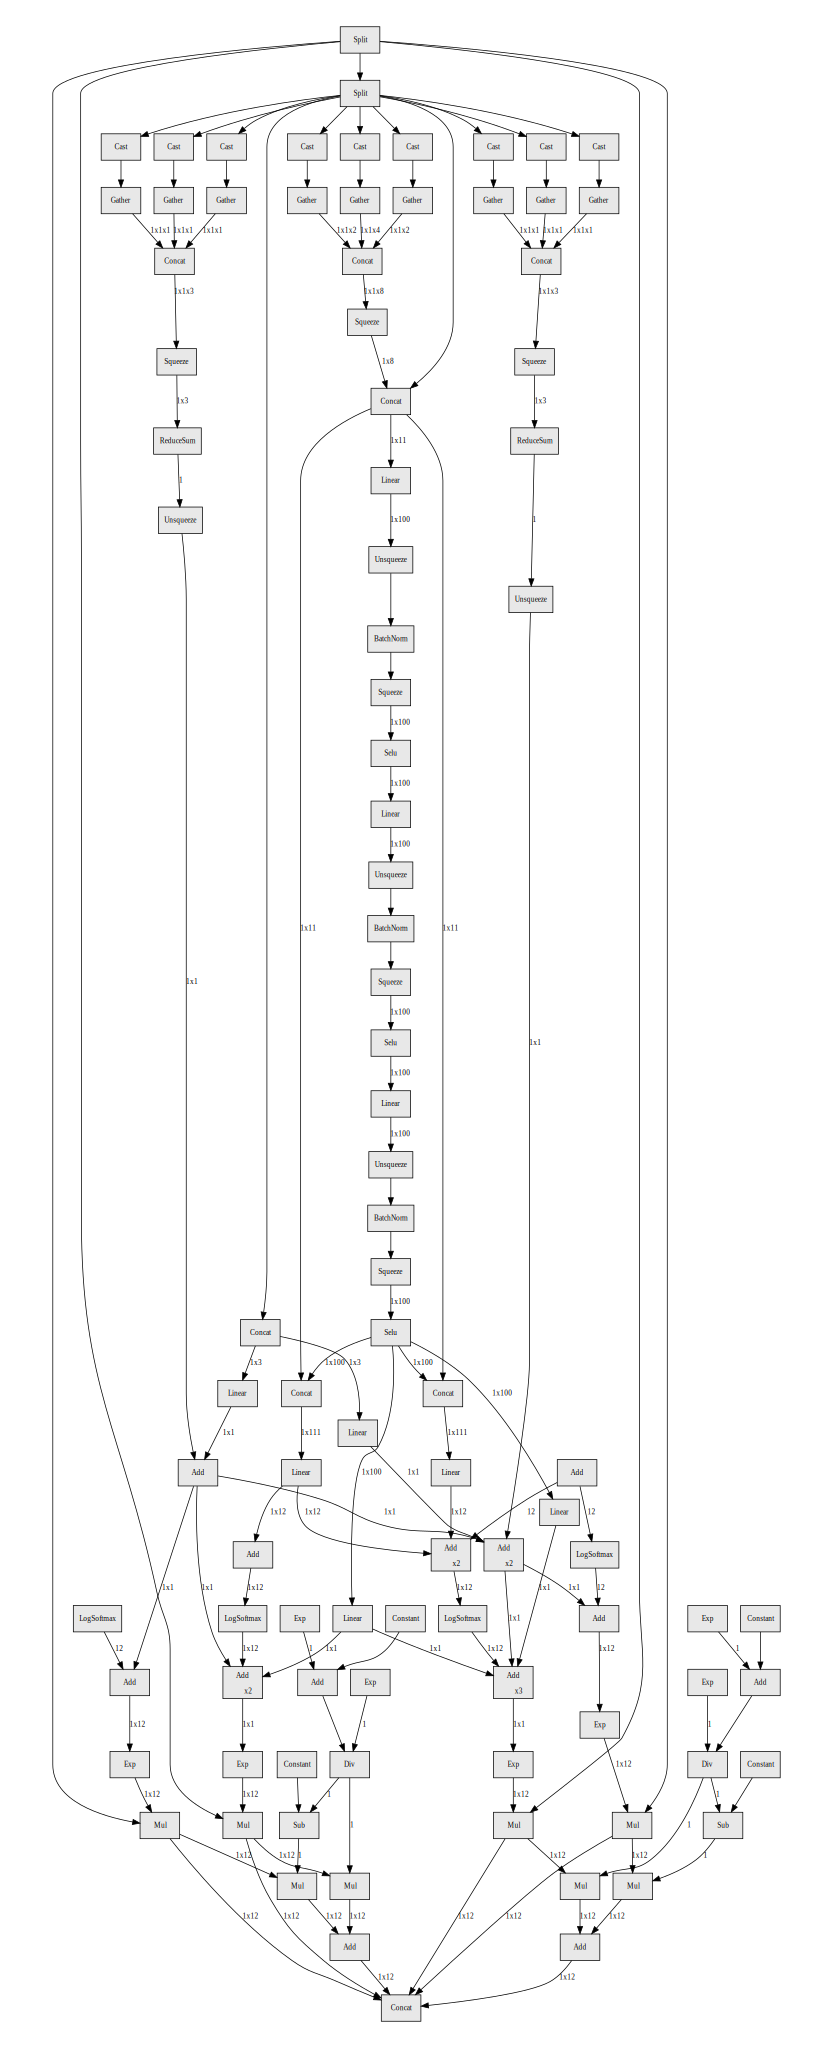

In [21]:
model.plot_graph()

Hyperparameter Bayesian grid search functionality is also included. To do so, use the PUNPPCILossOptimizer:

In [22]:
# Model - Make, Fit and Predict
opt = pn.PUNPPCIClaimOptimizer(n_iter=10)

Training may take some time an

Auto detect categorical dimensions to be: [(1, 15), (2, 2), (3, 101)]
Setting maximum learn rate to 0.1.
Setting epochs for training model to 4
  epoch       train_loss    valid_loss     dur
-------  ---------------  ------------  ------
      1  4662263156.8264    86999.0586  3.4460
      2   636896.3562    87113.3516  5.4493
      3   127862.0178    86957.6592  3.7603
      4   131478.0630    86797.7627  3.5762
Score: Loss = 85689.45355156639
Auto detect categorical dimensions to be: [(1, 15), (2, 2), (3, 101)]
Setting maximum learn rate to 0.1.
Setting epochs for training model to 4
  epoch      train_loss    valid_loss     dur
-------  --------------  ------------  ------
      1  174396982.5764    84422.4014  3.3527
      2  6230200001.9285    84538.6602  3.2111
      3   178731.8486    84618.2207  3.1423
      4   565034.9175    83999.6914  3.1122
Score: Loss = 88758.24352245689
Auto detect categorical dimensions to be: [(1, 15), (2, 2), (3, 101)]
Setting maximum learn rate to 0.

Setting maximum learn rate to 0.01.
Setting epochs for training model to 12
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    88156.0129    88573.5498  4.1968
      2    87498.8328    88120.0439  4.1896
      3    87446.8630    88076.9922  3.6841
      4    87295.5674    87839.4844  3.9069
      5    87155.2112    87721.4639  3.3403
      6    86995.9087    87634.5703  3.6121
      7    87019.6152    87665.8955  3.3654
      8    86995.7808    87586.2393  3.4653
      9    86904.0623    87575.2119  3.4668
     10    86854.9043    87547.0693  4.4481
     11    87028.8345    87537.4209  3.8732
     12    86972.3047    87702.9707  3.4311
Score: Loss = 84288.46171711301
best score: -88001.86706813295, best params {'l1_l2_linear': 4.200058615103415e-05, 'l2_bias_residual': 0.014484527579930122, 'l2_weights_residual': 0.06639149783849943, 'layer_size': 256}
Auto detect categorical dimensions to be: [(1, 15), (2, 2), (3, 101)]
Setting maximum l

      3    86263.1370    85651.6787  1.5877
      4    86210.8823    85384.2402  1.6319
      5    87670.1873    85713.4307  1.5198
      6    86113.5388    85644.4883  1.6244
      7    86121.5740    85460.5205  1.4719
      8    86151.0430    86224.0967  1.9151
Score: Loss = 90301.67449323226
Auto detect categorical dimensions to be: [(1, 15), (2, 2), (3, 101)]
Setting maximum learn rate to 0.1.
Setting epochs for training model to 4
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   254123.5823    89103.5732  1.8200
      2    88488.7429    88493.1270  1.4581
      3    87771.0337    88182.3477  1.7249
      4    87336.7720    87857.1494  1.5283
Score: Loss = 84441.35807042298
best score: -86351.88787551329, best params {'l1_l2_linear': 0.03971997660836942, 'l2_bias_residual': 0.0015105082059632658, 'l2_weights_residual': 0.00601465992016616, 'layer_size': 256}
Auto detect categorical dimensions to be: [(1, 15), (2, 2), (3, 101)]
Settin

Setting maximum learn rate to 0.01.
Setting epochs for training model to 8
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    88924.2922    85954.5908  3.5263
      2    86945.5671    85835.6396  3.7029
      3    86809.6409    85761.7764  3.6725
      4    86892.2380    85782.3232  3.6590
      5    86843.3264    85804.1357  4.8128
      6    86697.1870    85798.6289  4.2150
      7    86656.8943    85775.9932  4.2902
      8    86642.5454    85751.3574  3.8412
Score: Loss = 86431.77820384527
Auto detect categorical dimensions to be: [(1, 15), (2, 2), (3, 101)]
Setting maximum learn rate to 0.01.
Setting epochs for training model to 12
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    86800.6851    85402.6104  3.5867
      2    86031.5217    85271.8398  4.4974
      3    86106.5393    85332.8271  4.4783
      4    86310.2200    85231.0762  3.5405
      5    85961.9263    85235.5557  3.7991

      6    89067.9414    85957.2910  13.1213
      7    88153.0154    85867.4512  12.9099
      8    88093.2515    85767.3760  13.3509
      9    88015.1467    85687.0400  13.6804
     10    88002.9905    85747.8662  13.8281
Score: Loss = 84246.19325680987
Auto detect categorical dimensions to be: [(1, 15), (2, 2), (3, 101)]
Setting maximum learn rate to 0.01.
Setting epochs for training model to 8
  epoch         train_loss    valid_loss      dur
-------  -----------------  ------------  -------
      1  177763410293.5234   219448.6582  13.3876
      2    90294.0549    83543.8447  13.2881
      3    88048.8469    83307.8105  12.9690
      4    88385.4351    83173.9932  14.2035
      5  2941038.0022    83319.2305  13.4833
      6   162938.0911    83274.9043  13.1721
      7    88856.4067    83198.0391  13.7541
      8    87812.8293    83135.0996  13.7129
Score: Loss = 87666.44419058207
Auto detect categorical dimensions to be: [(1, 15), (2, 2), (3, 101)]
Setting maximum learn rate to 0

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    88526.7102    86282.4541  3.7933
      2    87120.3870    86056.3340  3.5050
      3    86877.9575    85931.4521  3.8134
      4    86800.6543    85901.1377  3.5677
      5    86705.6821    85724.0273  4.2297
      6    86542.6013    85716.8369  4.3660
      7    86616.6953    85707.4551  3.7188
      8    86507.8838    85683.2490  4.1906
      9    86569.1470    85649.0615  3.6078
     10    86464.2920    85635.3682  3.8685
     11    86456.0991    85651.7246  3.5929
     12    86454.6750    85615.6914  3.8309
     13    86431.2236    85643.0830  3.5450
     14    86470.7874    85630.0830  3.9158
     15    86447.6436    85610.5283  4.2892
     16    86442.7820    85622.9268  3.6381
     17    86455.4924    85613.1396  3.7757
     18    86401.5149    85591.2988  3.6897
     19    86439.0767    85637.3359  4.4180
     20    86409.8533    85603.9189  3.8416
     21    86412.8533    85610.4

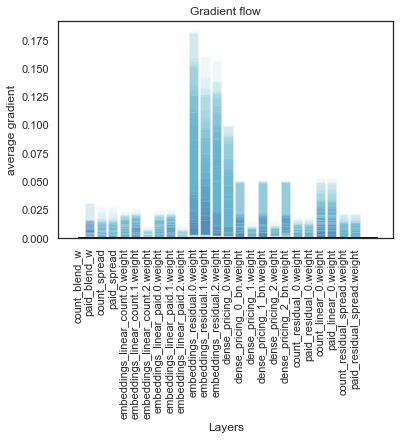

In [23]:
# Fit with optional weights
opt.fit(ds.X(opt), ds.y(opt), w=ds.w(opt))

With the true data, we can benchmark the model against the the standard PPCI model.

This calculates the sum squared error of the PUNPPCI and the PPCI methods vs the true bottom half of the triangle.

In [24]:
ds_true = pn.InsuranceDataset(
    features=df[["carrier", "flight", "departing", "destination", "distance"]],
    origin=df.origin_date,
    exposure=None,   # Exposure weight is optional
    claim_count=df[["claim_count_{}".format(x) for x in range(0, num_cols)]],
    claim_paid=df[["claim_paid_{}".format(x) for x in range(0, num_cols)]]
)

In [25]:
bench_mod = pn.benchmark(ds, ds_true, model, ppci)
bench_mod

(                       claim_count_0  claim_count_1  claim_count_2  \
 PUNPPCIClaimRegressor            0.0      23.743070    1184.674938   
 PPCIRegressor                    0.0       3.553913      13.783520   
 
                        claim_count_3  claim_count_4  claim_count_5  \
 PUNPPCIClaimRegressor     2738.42224    4269.433848    5059.269025   
 PPCIRegressor              127.56285     646.728929    1451.163370   
 
                        claim_count_6  claim_count_7  claim_count_8  \
 PUNPPCIClaimRegressor    5864.718093    6638.250938    7238.384824   
 PPCIRegressor            2059.786118    2401.645430    2953.822256   
 
                        claim_count_9  ...  claim_paid_2  claim_paid_3  \
 PUNPPCIClaimRegressor    8085.536688  ...  4.580819e+09  1.193406e+10   
 PPCIRegressor            3385.148161  ...  2.671256e+08  1.067953e+09   
 
                        claim_paid_4  claim_paid_5  claim_paid_6  claim_paid_7  \
 PUNPPCIClaimRegressor  2.393424e+10  3.460377e+1

Lower is better - use the right model for the right dataset!

With the true data, the actual vs model relationships for each factor can also be benchmarked:

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a300bc978>,
       dtype=object))

<Figure size 504x792 with 0 Axes>

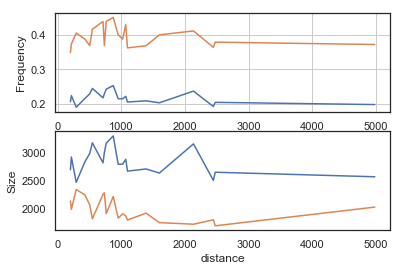

In [26]:
pn.plot_actual_vs_model(ds_true, model, "distance")

Partial dependence works for the Optimizer in the same way as the Regressor:

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a30040e48>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a3003c198>})

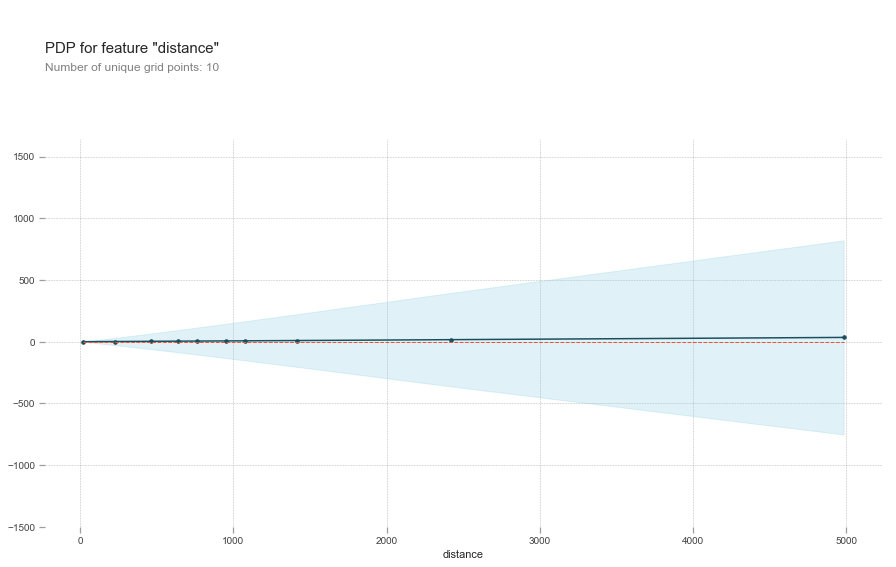

In [31]:
# Partial Dependence - Frequency
opt.plot_pdp_frequency(ds, 'distance')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a300181d0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a3000d710>})

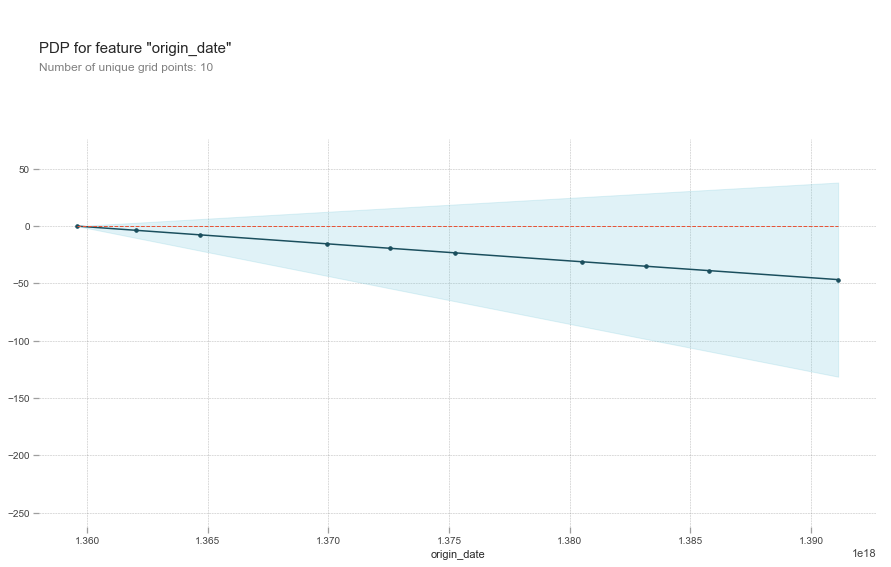

In [32]:
opt.plot_pdp_frequency(ds, 'origin_date')